In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from prophet import Prophet
import joblib
import warnings
warnings.filterwarnings('ignore')

c:\Users\kalay\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading the dataset
df = pd.read_csv("C:/Users/kalay/OneDrive/Desktop/unified p/Electric Vehicle Sales by State in India.csv")
# first few rows of the dataset
print(df.head())

     Year Month_Name      Date           State         Vehicle_Class  \
0  2014.0        jan  1/1/2014  Andhra Pradesh       ADAPTED VEHICLE   
1  2014.0        jan  1/1/2014  Andhra Pradesh  AGRICULTURAL TRACTOR   
2  2014.0        jan  1/1/2014  Andhra Pradesh             AMBULANCE   
3  2014.0        jan  1/1/2014  Andhra Pradesh   ARTICULATED VEHICLE   
4  2014.0        jan  1/1/2014  Andhra Pradesh                   BUS   

  Vehicle_Category Vehicle_Type  EV_Sales_Quantity  
0           Others       Others                0.0  
1           Others       Others                0.0  
2           Others       Others                0.0  
3           Others       Others                0.0  
4              Bus          Bus                0.0  


In [3]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'],errors='coerce')

In [4]:
# Check for null values
print(df.isnull().sum())

Year                 0
Month_Name           0
Date                 0
State                0
Vehicle_Class        0
Vehicle_Category     0
Vehicle_Type         0
EV_Sales_Quantity    0
dtype: int64


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96845 entries, 0 to 96844
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Year               96845 non-null  float64       
 1   Month_Name         96845 non-null  object        
 2   Date               96845 non-null  datetime64[ns]
 3   State              96845 non-null  object        
 4   Vehicle_Class      96845 non-null  object        
 5   Vehicle_Category   96845 non-null  object        
 6   Vehicle_Type       96845 non-null  object        
 7   EV_Sales_Quantity  96845 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 5.9+ MB
None


In [6]:
# Filling missing values categorical data
df['EV_Sales_Quantity'].fillna(df['EV_Sales_Quantity'].median(), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

In [7]:
# Create Date-related Columns
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Month_Name'] = df['Date'].dt.month_name()
df['Quarter'] = df['Date'].dt.to_period('Q')

In [8]:
# Reset index
df.reset_index(drop=True, inplace=True)

In [9]:
df.drop_duplicates(inplace=True)

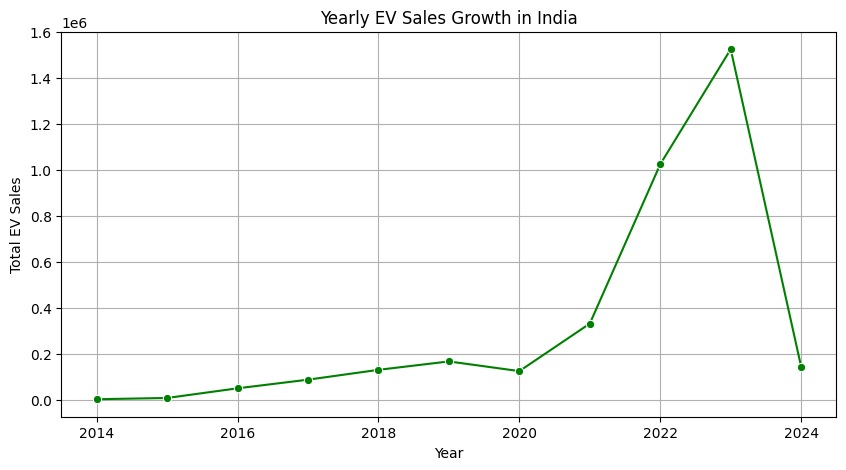

In [10]:
plt.figure(figsize=(10,5))
yearly_sales = df.groupby('Year')['EV_Sales_Quantity'].sum().reset_index()
sns.lineplot(data=yearly_sales, x='Year', y='EV_Sales_Quantity', marker='o', color='green')
plt.title("Yearly EV Sales Growth in India")
plt.xlabel("Year")
plt.ylabel("Total EV Sales")
plt.grid(True)
plt.show()

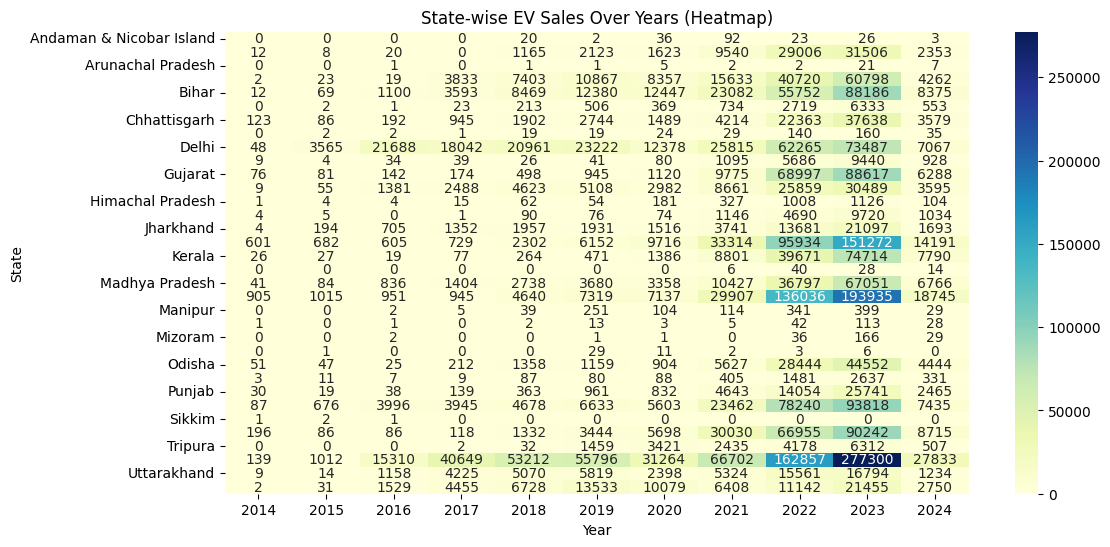

In [11]:
pivot_state = df.pivot_table(values='EV_Sales_Quantity', index='State', columns='Year', aggfunc='sum')
plt.figure(figsize=(12,6))
sns.heatmap(pivot_state, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title("State-wise EV Sales Over Years (Heatmap)")
plt.xlabel("Year")
plt.ylabel("State")
plt.show()

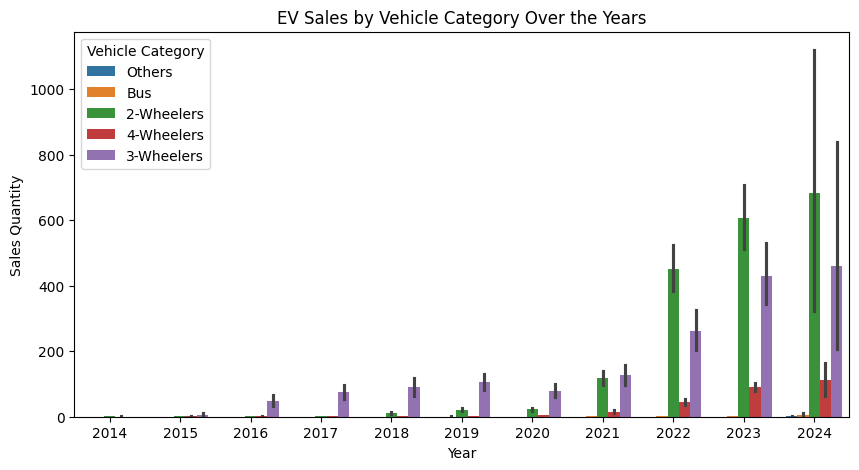

In [12]:
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='Year', y='EV_Sales_Quantity', hue='Vehicle_Category', palette='tab10')
plt.title("EV Sales by Vehicle Category Over the Years")
plt.xlabel("Year")
plt.ylabel("Sales Quantity")
plt.legend(title='Vehicle Category')
plt.show()

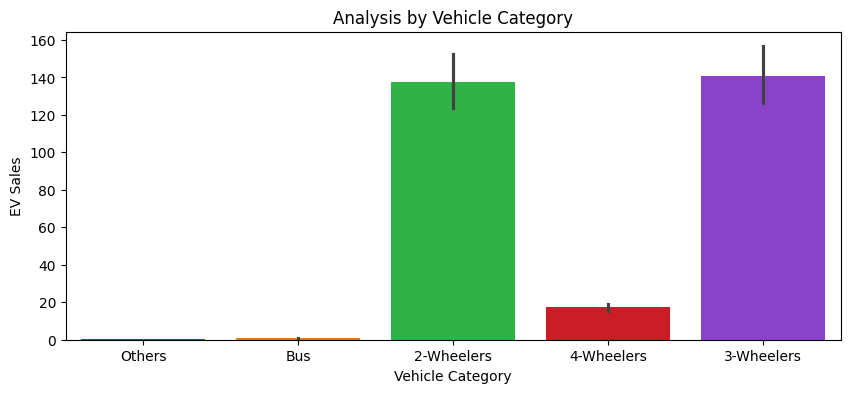

In [13]:
plt.figure(figsize=(10,4))
sns.barplot(x='Vehicle_Category',
y='EV_Sales_Quantity',data=df, hue='Vehicle_Category',palette='bright')
plt.title('Analysis by Vehicle Category')
plt.xlabel('Vehicle Category')
plt.ylabel('EV Sales')
plt.xticks(rotation=0);

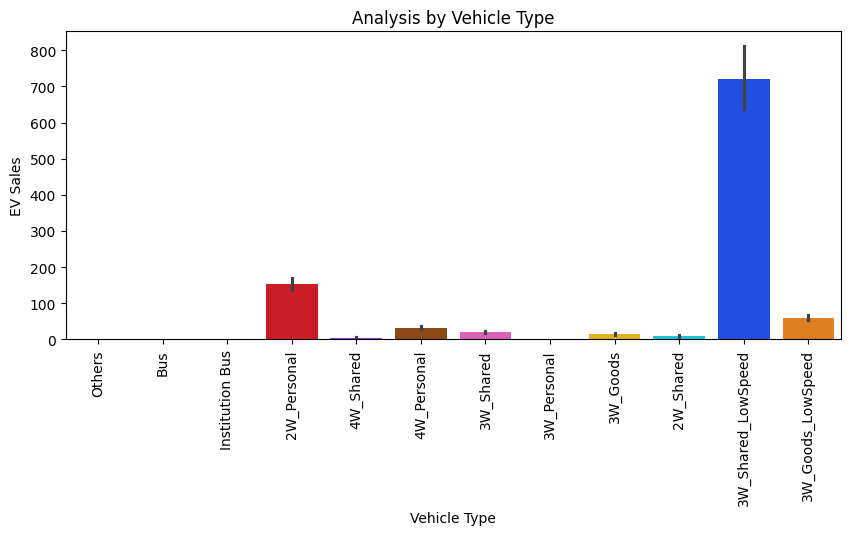

In [14]:
plt.figure(figsize=(10,4))
sns.barplot(x='Vehicle_Type', y='EV_Sales_Quantity',data=df,hue='Vehicle_Type', palette='bright')
plt.title('Analysis by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('EV Sales')
plt.xticks(rotation=90);

In [15]:
 # Extract Month and Day from the Date column
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [16]:
# Clean Month_Name column
df["Month_Name"] = df["Month_Name"].str.strip().str.capitalize()

# 'Jan', 'Feb', map them to full names:
month_map = {
    "Jan": "January", "Feb": "February", "Mar": "March", "Apr": "April",
    "May": "May", "Jun": "June", "Jul": "July", "Aug": "August",
    "Sep": "September", "Oct": "October", "Nov": "November", "Dec": "December"
}
df["Month_Name"] = df["Month_Name"].replace(month_map)

# Now use the fixed month_order
month_order = ["January","February","March","April","May","June", "July","August","September","October","November","December"]

In [17]:
df['Month'] = df['Month'].astype(str).str.lower().map(month_map)

In [18]:
df["Month_Name"] = df["Month_Name"].replace(month_map)

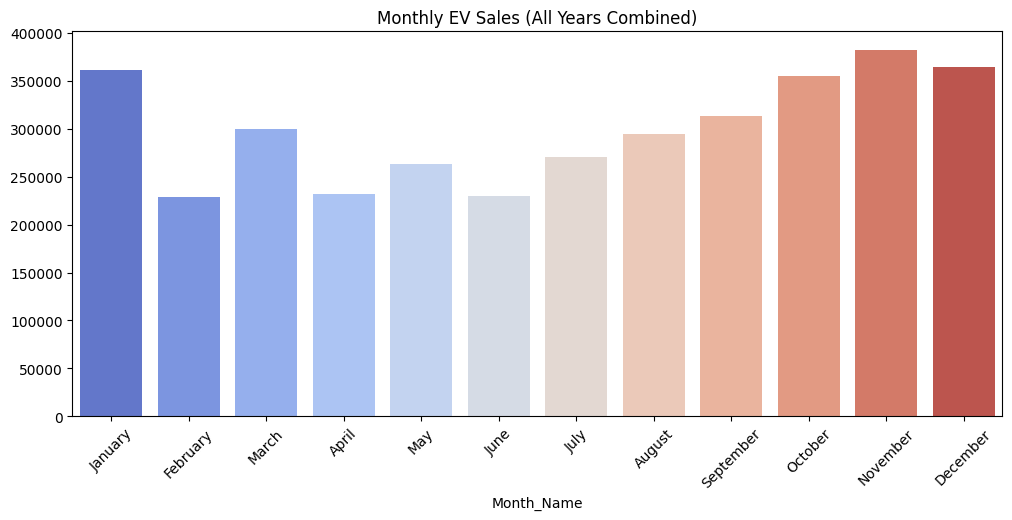

In [19]:
monthly_sales = df.groupby("Month_Name")["EV_Sales_Quantity"].sum().reindex(month_order)

# Drop missing months before plotting
monthly_sales = monthly_sales.dropna()

plt.figure(figsize=(12,5))
sns.barplot(x=monthly_sales.index, y=monthly_sales.values, palette="coolwarm")
plt.title("Monthly EV Sales (All Years Combined)")
plt.xticks(rotation=45)
plt.show()


In [20]:
#TIME SERIES FORECASTING (Prophet Model)

# Prepare data for Prophet
ts = df.groupby('Date')['EV_Sales_Quantity'].sum().reset_index()
ts = ts.rename(columns={'Date': 'ds', 'EV_Sales_Quantity': 'y'})

In [21]:
# Prophet model
model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=False)
model_prophet.fit(ts)

12:55:49 - cmdstanpy - INFO - Chain [1] start processing
12:55:49 - cmdstanpy - INFO - Chain [1] done processing


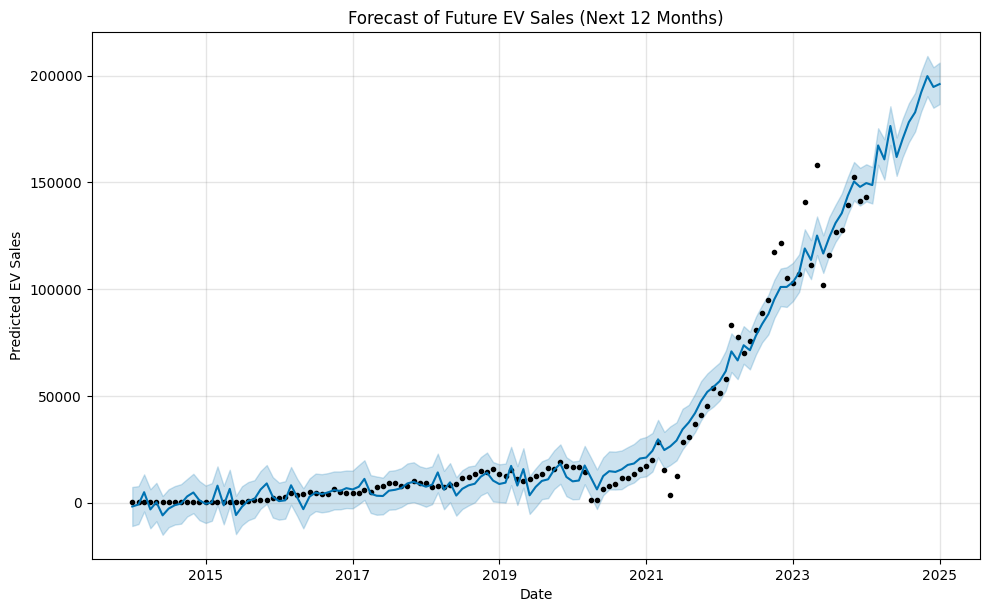

In [22]:
# Forecast next 12 months
future = model_prophet.make_future_dataframe(periods=12, freq='M')
forecast = model_prophet.predict(future)

# Plot forecast
fig1 = model_prophet.plot(forecast)
plt.title("Forecast of Future EV Sales (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Predicted EV Sales")
plt.show()

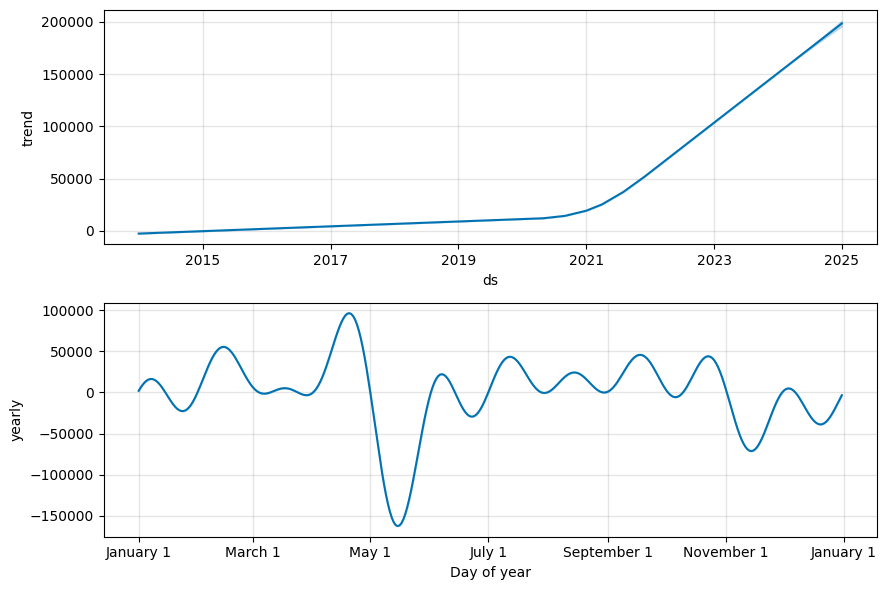

In [23]:
#COMPONENTS of the forecast
fig2 = model_prophet.plot_components(forecast)

In [24]:
# Random Forest
df_model = df.copy()
df_model['Quarter'] = df_model['Quarter'].astype(str)
cat_cols = df_model.select_dtypes(include=['object', 'category']).columns.tolist()
df_encoded = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

In [25]:
X = df_encoded.drop('EV_Sales_Quantity', axis=1)
y = df_encoded['EV_Sales_Quantity']

In [26]:
# Drop datetime columns
datetime_cols = X.select_dtypes(include=['datetime64[ns]']).columns
X = X.drop(columns=datetime_cols)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
model_rf = RandomForestRegressor(n_estimators=150, random_state=42)  # Increased estimators
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

In [29]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"🔹 Random Forest RMSE: {rmse:.2f}")
print(f"🔹 Random Forest R² Score: {r2:.4f}")

🔹 Random Forest RMSE: 130.53
🔹 Random Forest R² Score: 0.9346


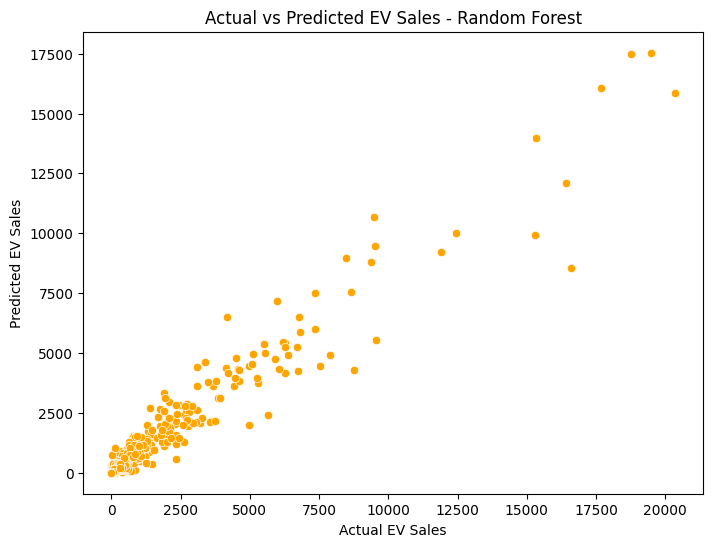

In [30]:
# Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, color='orange')
plt.xlabel("Actual EV Sales")
plt.ylabel("Predicted EV Sales")
plt.title("Actual vs Predicted EV Sales - Random Forest")
plt.show()

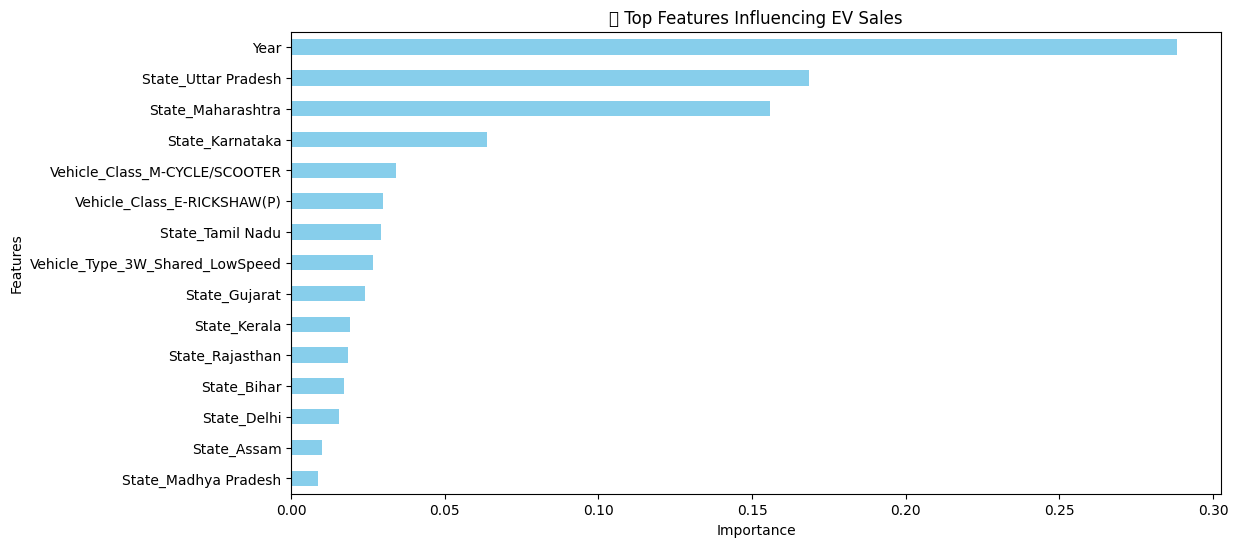

In [31]:
# ✅ Feature Importance Visualization
if hasattr(model_rf, "feature_importances_") and len(model_rf.feature_importances_) > 0:
    feat_importance = pd.Series(model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    plt.figure(figsize=(12,6))
    feat_importance.head(15).plot(kind='barh', color='skyblue')
    plt.title("🌟 Top Features Influencing EV Sales")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("🌟 Top Features Influencing EV Sales")
    print("Feature importance visualization unavailable for this data selection.")


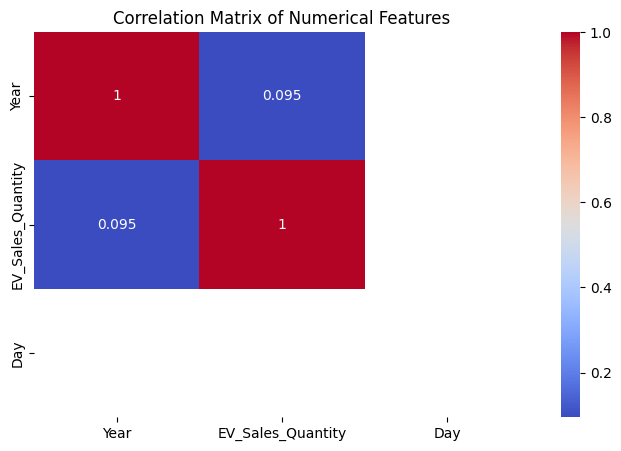

In [32]:
#Correlation Heatmap
corr = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [33]:
#Linear Regression for Comparison
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression RMSE: {rmse_lr:.2f}")
print(f"Linear Regression R² Score: {r2_lr:.4f}")

Linear Regression RMSE: 482.70
Linear Regression R² Score: 0.1053


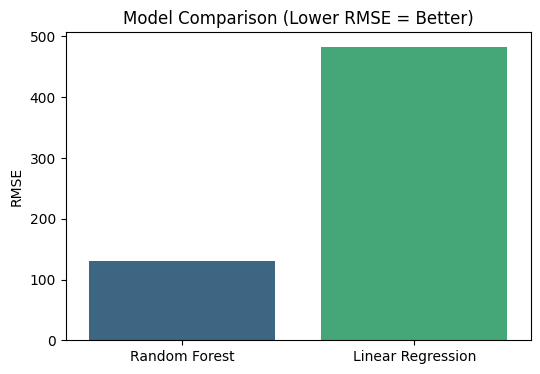

In [34]:
#Model Comparison Bar Chart
plt.figure(figsize=(6,4))
models = ['Random Forest', 'Linear Regression']
rmse_scores = [rmse, rmse_lr]
sns.barplot(x=models, y=rmse_scores, palette='viridis')
plt.title('Model Comparison (Lower RMSE = Better)')
plt.ylabel('RMSE')
plt.show()

In [35]:
# Save model and feature columns
joblib.dump(model_rf, "ev_sales_model.pkl")
joblib.dump(model_prophet, "forecast_model.pkl")

# Save the feature names used during training
joblib.dump(X_train.columns.tolist(), "model_features.pkl")

print("✅ Models and feature names saved successfully.")

✅ Models and feature names saved successfully.
